# 归一化后加入sigmoid激活函数之后训练更快

In [1]:
import datetime
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib import gridspec
from tensorflow import keras
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import function
from setting import *
from Comparison_of_Manifold_Learning_methods import *


None


In [2]:


@function.Defun(dtype, dtype, dtype, dtype)
def DoublySNGrad(logits, epsilon, dprev, dpout):
    '''
    函数名的意思便是，连续的sign的梯度
    给定ξ（epsilon）便可用论文2.4 Reparametrization via Stochastic Neur中提到的方法来进行重参数的采样
    '''
    prob = 1.0 / (1 + tf.exp(-logits))
    yout = (tf.sign(prob - epsilon) + 1.0) / 2.0

    # unbiased
    dlogits = prob * (1 - prob) * (dprev + dpout)

    depsilon = dprev
    return dlogits, depsilon

    # 这里应该是使用了TensorFlow中的梯度重写


@function.Defun(dtype, dtype, grad_func=DoublySNGrad)
def DoublySN(logits, epsilon):
    prob = 1.0 / (1 + tf.exp(-logits))
    yout = (tf.sign(prob - epsilon) + 1.0) / 2.0
    return yout, prob


class VAE_stoc_neuron:
    def __init__(self):
        print("初始化自编码器")
        self.encoder_model = self.encoder()
        self.encoder_model.summary()
        self.decoder_model = self.decoder()
        self.decoder_model.summary()

    def cycle(self, input):
        input = tf.reshape(input, [-1, dim_input])
        hencode = self.encoder_model(input)
        hepsilon = tf.ones(shape=tf.shape(hencode), dtype=dtype) * .5
        yout, pout = DoublySN(hencode, hepsilon)
        # yout = tf.convert_to_tensor(yout,tf.float32)
        yout = tf.reshape(yout, [-1, dim_hidden])
        self.latent_code = yout
        # yout.set_shape([batch_size,dim_hidden])
        print(yout.shape)
        output = self.decoder_model(yout)
        output = tf.reshape(output, [-1, image_h, image_w])
        return output

    def encoder(self):
        input = keras.layers.Input([dim_input])
        fc = keras.layers.Dense(dim_hidden)(input)
        output = fc
        return keras.models.Model(input, output)

    def decoder(self):
        input = keras.layers.Input([dim_hidden])
        fc = keras.layers.Dense(dim_input,activation=tf.nn.sigmoid)(input)
        output = fc
        return keras.models.Model(input, output)


class dataset:
    def __init__(self, data):
        self.dataset = tf.data.Dataset.from_tensor_slices(
            (data)).repeat().batch(batch_size).shuffle(buffer_size=128)
        self.iterator = self.dataset.make_initializable_iterator()
        self.next_element = self.iterator.get_next()


def trian(train_model):
    vae = VAE_stoc_neuron()
    (train_images, train_labels), (test_images,
                                   test_labels) = keras.datasets.mnist.load_data()
    train_images = train_images/255.0
    test_images = test_images/255.0
    train_images_dataset = dataset(train_images)

    x = tf.placeholder(dtype, [batch_size, image_w, image_h])
    xout = vae.cycle(x)
    monitor = tf.nn.l2_loss(xout - x, name=None)
    loss = monitor

    optimizer = tf.train.AdamOptimizer(learning_rate)
    # optimizer = tf.train.RMSPropOptimizer(learning_rate)
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

    # Tensorboard visualization
    tf.summary.scalar(name='Cycle Loss', tensor=monitor)
    summary_op = tf.summary.merge_all()
    global_step = 0
    # Saving the model
    saver = tf.train.Saver()
    print("计算图构建完毕")
    with tf.Session() as sess:
        sess.run(init)
        print("变量初始化完毕")
        if train_model:
            if not os.path.exists(results_path + folder_name):
                os.mkdir(results_path + folder_name)
                os.mkdir(tensorboard_path)
                os.mkdir(save_path)
            sess.run(train_images_dataset.iterator.initializer)
            # writer = tf.summary.FileWriter(logdir=tensorboard_path)
            for epoch in range(n_epochs):
                n_batches = int(len(train_images) / batch_size)
                for _ in range(n_batches):
                    batch = sess.run(train_images_dataset.next_element)
                    sess.run([train_op], feed_dict={x: batch})
                    if _ % 50 == 0:
                        summary, cycle_loss = sess.run(
                            [summary_op, monitor], feed_dict={x: batch})
                        # writer.add_summary(summary,global_step)
                        print("Epoch: {}, iteration: {}".format(epoch, _))
                        print("Cycle loss: {}".format(cycle_loss))
                    global_step += 1
            print("保存路径:"+save_path)
            saver.save(sess, save_path=save_path, global_step=global_step)
        else:
            all_results = os.listdir(results_path)
            all_results.sort()
            print(all_results)
            saver.restore(sess, save_path=tf.train.latest_checkpoint(
                results_path + '/' + all_results[-1] + '/save/'))
            print("原始图片的降维可视化分布")
            Comparison_of_Manifold_Learning_methods(train_images[:batch_size].reshape(-1,image_h*image_w),train_labels[:batch_size])
            
            img,latent_code = sess.run([xout,vae.latent_code], feed_dict={x: train_images[:batch_size]})
            print("latent code的降维可视化分布")
            Comparison_of_Manifold_Learning_methods(latent_code,train_labels[:batch_size])
            print("原始图片"+" >"*10)
            plt.figure(figsize=(60, 60))
            origin_img = np.hstack(train_images[:show_img_num])
            plt.imshow(origin_img, cmap=plt.cm.binary)
            plt.axis('off')
            plt.grid('off')
            plt.show()
            img = np.hstack(img[:show_img_num])
            print("重构图片"+" >"*10)
            plt.figure(figsize=(60, 60))
            plt.imshow(img, cmap=plt.cm.binary)
            plt.axis('off')
            plt.grid('off')
            plt.show()

In [3]:
trian(True)

初始化自编码器
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               50960     
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Shapes are always computed; don't

Epoch: 12, iteration: 150
Cycle loss: 1293.61083984375
Epoch: 12, iteration: 200
Cycle loss: 1176.1015625
Epoch: 12, iteration: 250
Cycle loss: 1181.51806640625
Epoch: 12, iteration: 300
Cycle loss: 1189.788330078125
Epoch: 12, iteration: 350
Cycle loss: 1161.07861328125
Epoch: 12, iteration: 400
Cycle loss: 1109.152099609375
Epoch: 12, iteration: 450
Cycle loss: 1119.835205078125
Epoch: 13, iteration: 0
Cycle loss: 1070.207763671875
Epoch: 13, iteration: 50
Cycle loss: 1289.793212890625
Epoch: 13, iteration: 100
Cycle loss: 1247.80322265625
Epoch: 13, iteration: 150
Cycle loss: 1179.638671875
Epoch: 13, iteration: 200
Cycle loss: 1245.3468017578125
Epoch: 13, iteration: 250
Cycle loss: 1186.1583251953125
Epoch: 13, iteration: 300
Cycle loss: 1081.5810546875
Epoch: 13, iteration: 350
Cycle loss: 1059.4185791015625
Epoch: 13, iteration: 400
Cycle loss: 1041.0272216796875
Epoch: 13, iteration: 450
Cycle loss: 1050.2330322265625
Epoch: 14, iteration: 0
Cycle loss: 1032.6153564453125
Epoch

Epoch: 27, iteration: 200
Cycle loss: 954.4189453125
Epoch: 27, iteration: 250
Cycle loss: 901.0195922851562
Epoch: 27, iteration: 300
Cycle loss: 882.284912109375
Epoch: 27, iteration: 350
Cycle loss: 881.6611328125
Epoch: 27, iteration: 400
Cycle loss: 838.3522338867188
Epoch: 27, iteration: 450
Cycle loss: 879.629150390625
Epoch: 28, iteration: 0
Cycle loss: 915.3836669921875
Epoch: 28, iteration: 50
Cycle loss: 891.7190551757812
Epoch: 28, iteration: 100
Cycle loss: 990.846435546875
Epoch: 28, iteration: 150
Cycle loss: 853.3232421875
Epoch: 28, iteration: 200
Cycle loss: 849.3963012695312
Epoch: 28, iteration: 250
Cycle loss: 897.3200073242188
Epoch: 28, iteration: 300
Cycle loss: 980.85986328125
Epoch: 28, iteration: 350
Cycle loss: 943.392822265625
Epoch: 28, iteration: 400
Cycle loss: 985.1676025390625
Epoch: 28, iteration: 450
Cycle loss: 879.7135009765625
Epoch: 29, iteration: 0
Cycle loss: 914.5811767578125
Epoch: 29, iteration: 50
Cycle loss: 873.125
Epoch: 29, iteration: 1

Epoch: 42, iteration: 250
Cycle loss: 748.882568359375
Epoch: 42, iteration: 300
Cycle loss: 750.644775390625
Epoch: 42, iteration: 350
Cycle loss: 729.8822631835938
Epoch: 42, iteration: 400
Cycle loss: 773.5523681640625
Epoch: 42, iteration: 450
Cycle loss: 779.6849365234375
Epoch: 43, iteration: 0
Cycle loss: 780.4732666015625
Epoch: 43, iteration: 50
Cycle loss: 910.9415283203125
Epoch: 43, iteration: 100
Cycle loss: 819.427001953125
Epoch: 43, iteration: 150
Cycle loss: 906.170654296875
Epoch: 43, iteration: 200
Cycle loss: 766.9034423828125
Epoch: 43, iteration: 250
Cycle loss: 698.9183349609375
Epoch: 43, iteration: 300
Cycle loss: 838.652587890625
Epoch: 43, iteration: 350
Cycle loss: 857.4281005859375
Epoch: 43, iteration: 400
Cycle loss: 804.7105712890625
Epoch: 43, iteration: 450
Cycle loss: 848.474609375
Epoch: 44, iteration: 0
Cycle loss: 793.0873413085938
Epoch: 44, iteration: 50
Cycle loss: 831.6425170898438
Epoch: 44, iteration: 100
Cycle loss: 787.1865234375
Epoch: 44,

初始化自编码器
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               50960     
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Shapes are always computed; don't

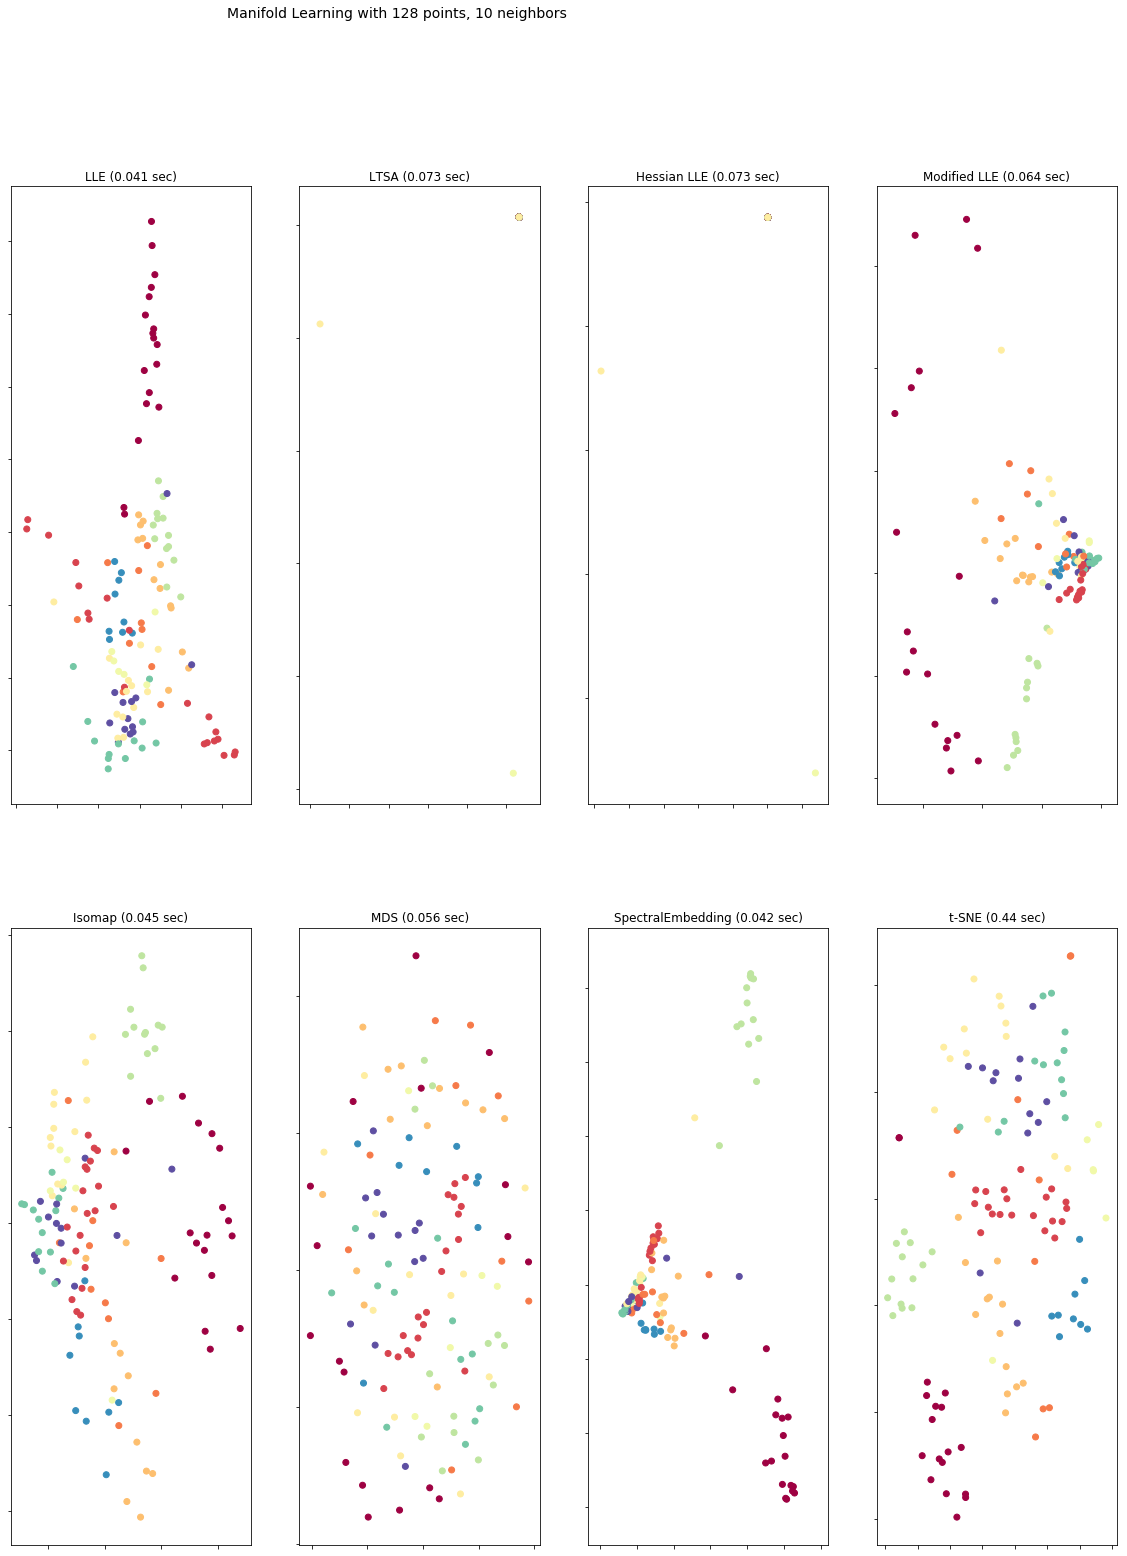

latent code的降维可视化分布
standard: 0.017 sec
ltsa: 0.041 sec
hessian: 0.056 sec
modified: 0.05 sec
Isomap: 0.013 sec
MDS: 0.046 sec
SpectralEmbedding: 0.0086 sec
t-SNE: 0.42 sec


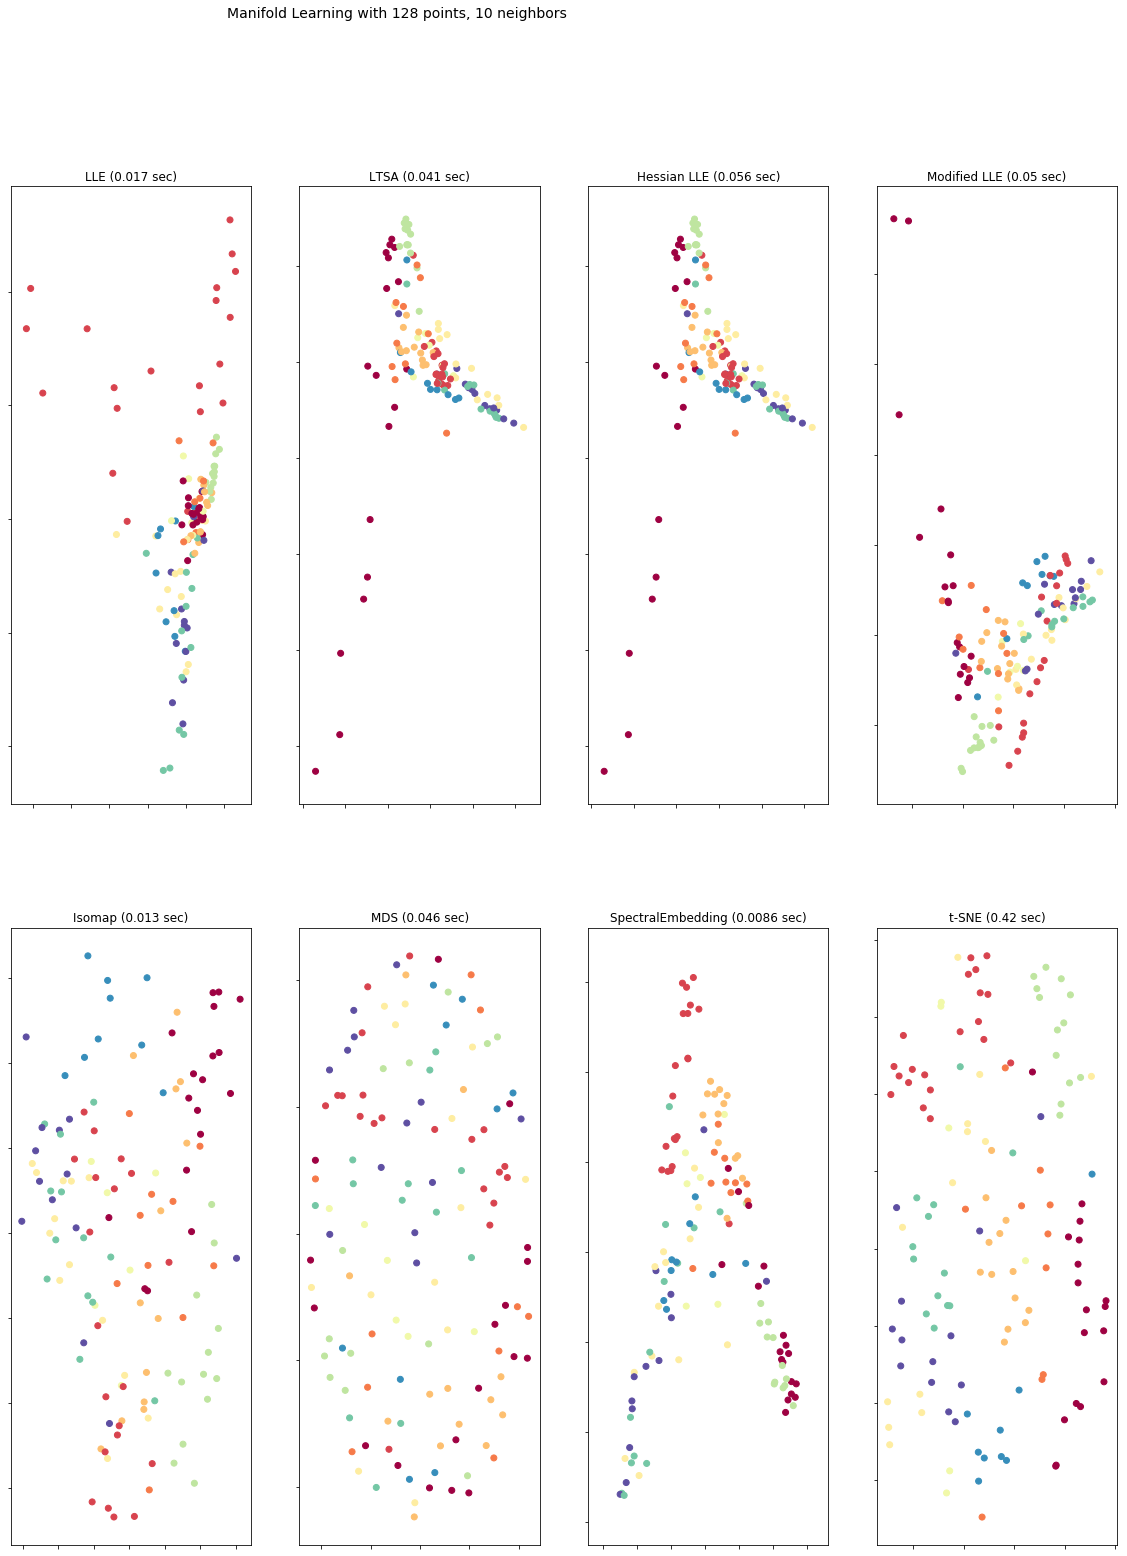

原始图片 > > > > > > > > > >


/home/tom/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


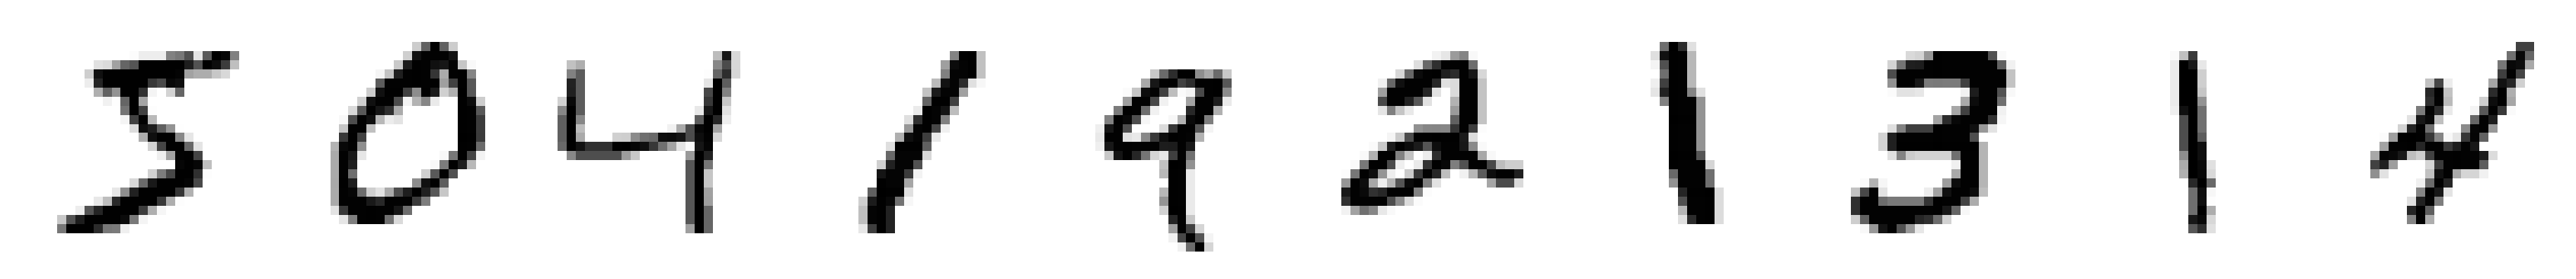

重构图片 > > > > > > > > > >


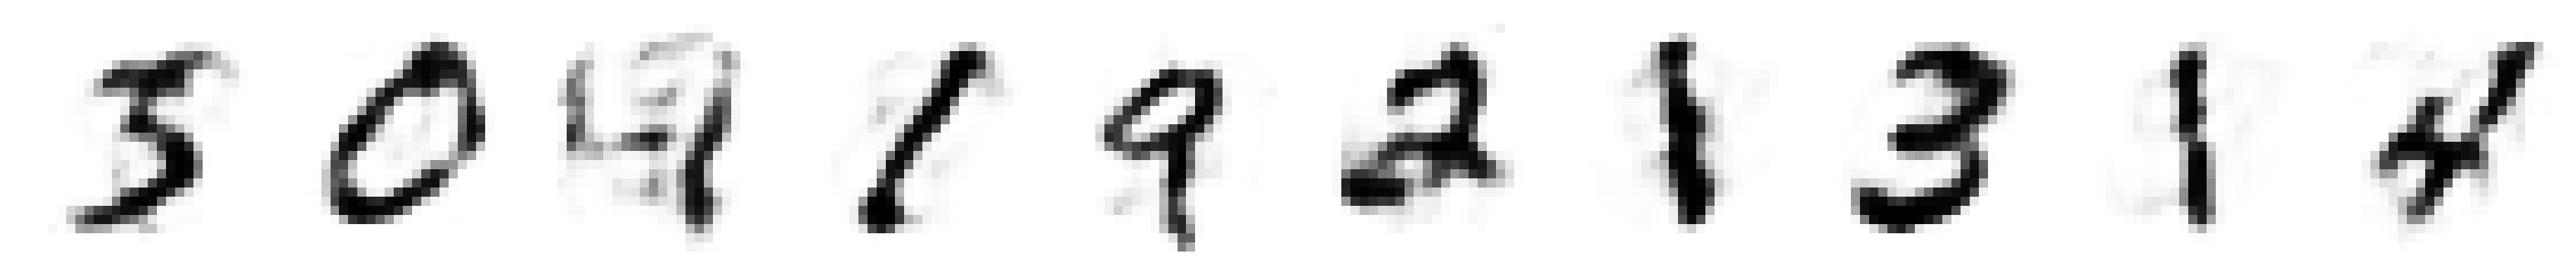

In [3]:
trian(False)